In [4]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pickle
import os
import plotly.express as px
import base64
from scipy.interpolate import interp1d
import re

In [10]:
#ForKK Local
DataPath = "./XC-CleanedData/**/*.csv"
FilteredDataPath4CO = "./GeneratedData/"
FilteredDataPathCenterlines = "./GeneratedData/Centerlines"
FilteredDataPathPlayback = "./GeneratedData/playback/"

# Feature Engineering

In [6]:
ListOfScenarios=["CP1","CP2","CP3","CP5","CP6","CP7","CP8"]
MaxDistance=35
window_size = 5  # This can be changed depending on how much smoothing you want
kernel = np.ones(window_size) / window_size
OutputColumns = ["ApproachRate", "ApproachRateOther", 
                 "Rel_Pos_Magnitude", 
                 "ScenarioTime", 
                 "AccelA","AccelB",
                 "SteerA","SteerB",
                 "A_Head_Center_Distance","B_Head_Center_Distance",
                 "Filtered_A_Head_Velocity_Total","Filtered_B_Head_Velocity_Total",
                 "A_Turn", "B_Turn",
                 "Centerline_Offset_A", "Centerline_Offset_B",
                 'A_Indicator', 'B_Indicator',
                 "RelativeRotation"]
column_types = {'ScenarioTime': 'float64',
                'AccelA': 'float64',
                'AccelB': 'float64',
                'SteerA': 'float64',
                'SteerB': 'float64',
                'HeadPosXA': 'float64',
                'HeadPosYA': 'float64',
                'HeadPosZA': 'float64',
                'HeadPosXB': 'float64',
                'HeadPosYB': 'float64',
                'HeadPosZB': 'float64',
                'HeadrotYA': 'float64',
                'HeadrotYB': 'float64',
                'IndicatorsA': 'str',
                'IndicatorsB': 'str'
                }

required_columns = set(column_types.keys())

In [7]:
def load_centerlines(path):
    # Retrieve all Feather files in the directory
    files = glob.glob(os.path.join(path, '*.feather'))
    centerlines = {}

    # Load each file and store it in a dictionary
    for file in files:
        # Parse the scenario and car type from the filename
        base = os.path.basename(file)
        parts = base.replace('.feather', '').split('_')
        scenario = parts[1]
        car_type = parts[2]

        # Read the DataFrame
        df = pd.read_feather(file)
        
        # Use a tuple (scenario, car_type) as the key
        centerlines[(scenario, car_type)] = df
        print(f"Loaded centerline for {scenario} ({car_type}) from {file}")
    
    return centerlines

In [8]:
# Load all centerlines into a dictionary
centerlines = load_centerlines(FilteredDataPathCenterlines)

Loaded centerline for CP1 (B) from ./GeneratedData/Centerlines/centerline_CP1_B.feather
Loaded centerline for CP7 (B) from ./GeneratedData/Centerlines/centerline_CP7_B.feather
Loaded centerline for CP6 (A) from ./GeneratedData/Centerlines/centerline_CP6_A.feather
Loaded centerline for CP1 (A) from ./GeneratedData/Centerlines/centerline_CP1_A.feather
Loaded centerline for CP6 (B) from ./GeneratedData/Centerlines/centerline_CP6_B.feather
Loaded centerline for CP7 (A) from ./GeneratedData/Centerlines/centerline_CP7_A.feather
Loaded centerline for CP3 (B) from ./GeneratedData/Centerlines/centerline_CP3_B.feather
Loaded centerline for CP2 (A) from ./GeneratedData/Centerlines/centerline_CP2_A.feather
Loaded centerline for CP5 (B) from ./GeneratedData/Centerlines/centerline_CP5_B.feather
Loaded centerline for CP8 (B) from ./GeneratedData/Centerlines/centerline_CP8_B.feather
Loaded centerline for CP2 (B) from ./GeneratedData/Centerlines/centerline_CP2_B.feather
Loaded centerline for CP3 (A) fr

In [7]:
centerlines['CP2','B']

,Point_ID,HeadPosXB,HeadPosZB
0,0,-86.261300,-84.337100
1,1,-85.772400,-84.246274
2,2,-85.283505,-84.146347
3,3,-84.797559,-84.045799
4,4,-84.316451,-83.936448
...,...,...,...
395,395,28.612413,-0.949254
396,396,29.109668,-0.936590
397,397,29.606910,-0.937088
398,398,30.104153,-0.936207


In [8]:
def calculate_closest_distances_and_indices(path, centerline, col_x, col_y):
    offsets = []
    closest_indices = []
    for i in range(len(path)):
        point_x = path[col_x].iloc[i]
        point_y = path[col_y].iloc[i]
        distances = np.sqrt((centerline[col_x] - point_x)**2 + (centerline[col_y] - point_y)**2)
        closest_idx = np.argmin(distances)
        closest_distance = distances[closest_idx]
        offsets.append(closest_distance)
        closest_indices.append(closest_idx)
    return offsets, closest_indices

In [9]:
def get_driving_direction(scenario):
    # (left=>-1 right=>1)
    if scenario == "CP1":
        A_Turn = -1
        B_Turn = 0
    elif scenario == "CP2":
        A_Turn = -1
        B_Turn = 0
    elif scenario == "CP3":
        A_Turn = -1
        B_Turn = -1
    elif scenario == "CP5":
        A_Turn = -1
        B_Turn = -1
    elif scenario == "CP6":
        A_Turn = 1
        B_Turn = 0
    elif scenario == "CP7":
        A_Turn = 0
        B_Turn = 0
    elif scenario == "CP8":
        A_Turn = 1
        B_Turn = 1
    else:
        print("Unknown scenario")
        return 0, 0
    return A_Turn, B_Turn

In [10]:
def convert_indicator(indicator):
    if pd.isna(indicator):
        return 0
    elif 'LeftTrue' in indicator:
        return -1
    elif 'RightTrue' in indicator:
        return 1
    else:
        return 0

In [9]:
# Function to detect outliers based on start and end points
def detect_outliers_by_start_end(paths, median_start, median_end, col_x, col_y, threshold):
    cleaned_paths = []
    for path in paths:
        start_distance = np.sqrt((path[col_x].iloc[0] - median_start[col_x])**2 + (path[col_y].iloc[0] - median_start[col_y])**2)
        end_distance = np.sqrt((path[col_x].iloc[-1] - median_end[col_x])**2 + (path[col_y].iloc[-1] - median_end[col_y])**2)
        if start_distance <= threshold and end_distance <= threshold:
            cleaned_paths.append(path)
    return cleaned_paths

In [20]:
pd.options.mode.chained_assignment = None
CSVFiles = glob.glob(DataPath, recursive=True)
FinalFileList = []
for val in CSVFiles:
    Scenario = os.path.basename(val).split('-')[1].split('_')[0].upper()
    run = os.path.basename(val).split('-')[2].split('_')[0].upper()
    if Scenario in ListOfScenarios:
        try:
            df = pd.read_csv(val, sep=';', dtype=column_types)
        except Exception as e:
            print(f"An error occurred while reading {Scenario} at {run}: {e}")
            continue
        is_columns = set(df.columns)
        if not required_columns.issubset(is_columns):
            missing_columns = required_columns - is_columns
            print(f"DataFrame is missing columns: {missing_columns} {Scenario}{run}")
            continue
        # Head-Center Distance
        df['A_Head_Center_Distance'] = np.sqrt(df['HeadPosXA']**2 + df['HeadPosYA']**2 + df['HeadPosZA']**2)
        df['B_Head_Center_Distance'] = np.sqrt(df['HeadPosXB']**2 + df['HeadPosYB']**2 + df['HeadPosZB']**2)
        # Define dataframe inner area to be within a radius of MaxDistance = 35
        innerArea = df.loc[(df['A_Head_Center_Distance'] < MaxDistance)
                            & (df['B_Head_Center_Distance'] < MaxDistance)].copy().reset_index()
        if innerArea.shape[0] == 0:
            print("Skipping: ", Scenario, run)
            continue
        # Timeframe reset
        innerArea['DeltaTime'] = innerArea['ScenarioTime'].diff()
        innerArea['ScenarioTime']= innerArea['ScenarioTime'] - innerArea['ScenarioTime'].iloc[0]
        # todo: turn head_delta into vector
        # Delta positions along x,y,z axis
        innerArea['A_Head_DeltaX'] = innerArea['HeadPosXA'].diff()
        innerArea['A_Head_DeltaZ'] = innerArea['HeadPosZA'].diff()
        innerArea['A_Head_DeltaY'] = innerArea['HeadPosYA'].diff()
        innerArea['B_Head_DeltaX'] = innerArea['HeadPosXB'].diff()
        innerArea['B_Head_DeltaY'] = innerArea['HeadPosYB'].diff()
        innerArea['B_Head_DeltaZ'] = innerArea['HeadPosZB'].diff()
        # Velocity along x,y,z axis
        innerArea['A_Head_VelocityX'] = innerArea['A_Head_DeltaX'] / innerArea['DeltaTime']
        innerArea['A_Head_VelocityY'] = innerArea['A_Head_DeltaY'] / innerArea['DeltaTime']
        innerArea['A_Head_VelocityZ'] = innerArea['A_Head_DeltaZ'] / innerArea['DeltaTime']
        innerArea['B_Head_VelocityX'] = innerArea['B_Head_DeltaX'] / innerArea['DeltaTime']
        innerArea['B_Head_VelocityY'] = innerArea['B_Head_DeltaY'] / innerArea['DeltaTime']
        innerArea['B_Head_VelocityZ'] = innerArea['B_Head_DeltaZ'] / innerArea['DeltaTime']
        # Set start velocity at 0
        innerArea['A_Head_VelocityX'].iloc[0] =0#innerArea['A_Head_VelocityX'].iloc[1]
        innerArea['A_Head_VelocityY'].iloc[0] =0#innerArea['A_Head_VelocityY'].iloc[1]
        innerArea['A_Head_VelocityZ'].iloc[0] =0#innerArea['A_Head_VelocityZ'].iloc[1]
        innerArea['B_Head_VelocityX'].iloc[0] =0#innerArea['B_Head_VelocityX'].iloc[1]
        innerArea['B_Head_VelocityY'].iloc[0] =0#innerArea['B_Head_VelocityY'].iloc[1]
        innerArea['B_Head_VelocityZ'].iloc[0] =0#innerArea['B_Head_VelocityZ'].iloc[1]
        # Smooth velocity and get total velocity
        innerArea['Filtered_A_Head_VelocityX'] = np.convolve(innerArea['A_Head_VelocityX'], kernel, 'same')
        innerArea['Filtered_A_Head_VelocityY'] = np.convolve(innerArea['A_Head_VelocityY'], kernel, 'same')
        innerArea['Filtered_A_Head_VelocityZ'] = np.convolve(innerArea['A_Head_VelocityZ'], kernel, 'same')
        innerArea['Filtered_A_Head_Velocity_Total'] = np.sqrt(innerArea['Filtered_A_Head_VelocityX']**2 
                                                            + innerArea['Filtered_A_Head_VelocityY']**2 
                                                            + innerArea['Filtered_A_Head_VelocityZ']**2)
        innerArea['Filtered_B_Head_VelocityX'] = np.convolve(innerArea['B_Head_VelocityX'], kernel, 'same')
        innerArea['Filtered_B_Head_VelocityY'] = np.convolve(innerArea['B_Head_VelocityY'], kernel, 'same')
        innerArea['Filtered_B_Head_VelocityZ'] = np.convolve(innerArea['B_Head_VelocityZ'], kernel, 'same')
        innerArea['Filtered_B_Head_Velocity_Total'] = np.sqrt(innerArea['Filtered_B_Head_VelocityX']**2 
                                                            + innerArea['Filtered_B_Head_VelocityY']**2 
                                                            + innerArea['Filtered_B_Head_VelocityZ']**2)
        # Relative velocity along x,y,z axis
        innerArea['RelVelocity_X'] = innerArea['Filtered_A_Head_VelocityX'] - innerArea['Filtered_B_Head_VelocityX']
        innerArea['RelVelocity_Y'] = innerArea['Filtered_A_Head_VelocityY'] - innerArea['Filtered_B_Head_VelocityY']
        innerArea['RelVelocity_Z'] = innerArea['Filtered_A_Head_VelocityZ'] - innerArea['Filtered_B_Head_VelocityZ']
        # Relative total velocity
        innerArea['RelVelocity'] = np.sqrt(innerArea['RelVelocity_X']**2 
                                            + innerArea['RelVelocity_Y']**2 
                                            + innerArea['RelVelocity_Z']**2)
        # Relative distance along x,y,z axis
        innerArea['Rel_Distance_X'] = innerArea['HeadPosXA'] - innerArea['HeadPosXB']
        innerArea['Rel_Distance_Y'] = innerArea['HeadPosYA'] - innerArea['HeadPosYB']
        innerArea['Rel_Distance_Z'] = innerArea['HeadPosZA'] - innerArea['HeadPosZB']
        # Relative position distance
        innerArea['Rel_Pos_Magnitude'] = np.sqrt(innerArea['Rel_Distance_X']**2 
                                                + innerArea['Rel_Distance_Y']**2 
                                                + innerArea['Rel_Distance_Z']**2)
        # Measures the component of the relative velocity that is in the direction of the relative distance
        innerArea['Dot_Product'] = (innerArea['Rel_Distance_X'] * innerArea['RelVelocity_X'] 
                                    + innerArea['Rel_Distance_Y'] * innerArea['RelVelocity_Y'] 
                                    + innerArea['Rel_Distance_Z'] * innerArea['RelVelocity_Z'])
        # Normalizes this measure by the distance, 
        # providing a rate at which the two entities are closing in on each other
        innerArea['ApproachRate'] = innerArea['Dot_Product'] / innerArea['Rel_Pos_Magnitude']
        # Measures the component of the smoothed relative velocity that is in the direction of the relative distance
        innerArea['Dot_Product_Other'] = (innerArea['Rel_Distance_X'] * innerArea['Filtered_B_Head_VelocityX'] 
                                        + innerArea['Rel_Distance_Y'] * innerArea['Filtered_B_Head_VelocityY'] 
                                        + innerArea['Rel_Distance_Z'] * innerArea['Filtered_B_Head_VelocityZ'])
        # providing a rate at which the two entities are closing in on each other after smoothing
        innerArea['ApproachRateOther'] = innerArea['Dot_Product_Other'] / innerArea['Rel_Pos_Magnitude']
        # ToDo: Add intended Driving direction as a variable (left=>-1 right=>1) scenario-wise
        # Left turn: steer > 0, right turn: steer < 0
        # innerArea['A_Turn'] = np.where(innerArea['SteerA']>0, 1, 0)
        # innerArea['A_Turn'] = np.where(innerArea['SteerA']<0, -1, innerArea['A_Turn'])
        # innerArea['B_Turn'] = np.where(innerArea['SteerB']>0, 1, 0)
        # innerArea['B_Turn'] = np.where(innerArea['SteerB']<0, -1, innerArea['B_Turn'])
        innerArea['A_Turn'], innerArea['B_Turn'] = get_driving_direction(Scenario)
        # ToDo: compute center line
        centerline_A = centerlines[Scenario, 'A']
        centerline_B = centerlines[Scenario, 'B']
        # ToDo: compute offset from center line
        innerArea['Centerline_Offset_A'], _ = calculate_closest_distances_and_indices(innerArea, centerline_A, 'HeadPosXA', 'HeadPosZA')
        innerArea['Centerline_Offset_B'], _ = calculate_closest_distances_and_indices(innerArea, centerline_B, 'HeadPosXB', 'HeadPosZB')
        
        # ToDo: add Car B's indicator into -1=>1
        # Apply the function to the IndicatorA column
        innerArea['A_Indicator'] = innerArea['IndicatorsA'].apply(convert_indicator)
        innerArea['B_Indicator'] = innerArea['IndicatorsB'].apply(convert_indicator)
        # ToDo: Contemplate other line depended variables
        innerArea['RelativeRotation'] = innerArea['HeadrotYA']- innerArea['HeadrotYB']
        # plot_and_save(Scenario, run, innerArea)
        
        path = os.path.join(FilteredDataPath,Scenario+'_'+run+'.feather')
        innerArea[OutputColumns].to_feather(path)
        # pathPlayback = os.path.join(FilteredDataPathPlayback,Scenario+'_'+run+'.csv')
        # innerArea.to_csv(pathPlayback)
        FinalFileList.append(path)

Skipping:  CP5 NYC1
Skipping:  CP2 NYC1
Skipping:  CP1 NYC1
Skipping:  CP1 NYC25
Skipping:  CP1 ISR13
Skipping:  CP1 NYC9
Skipping:  CP5 ISR39
Skipping:  CP5 ISR38
Skipping:  CP2 ISR38
Skipping:  CP3 NYC2
Skipping:  CP2 NYC10
Skipping:  CP6 ISR11
DataFrame is missing columns: {'SteerB', 'HeadPosYB', 'HeadPosZA', 'SteerA', 'AccelB', 'HeadrotYA', 'HeadPosYA', 'AccelA', 'IndicatorsA', 'HeadrotYB', 'ScenarioTime', 'IndicatorsB', 'HeadPosXB', 'HeadPosXA', 'HeadPosZB'} CP1NYC42
Skipping:  CP3 NYC11
Skipping:  CP7 NYC16
Skipping:  CP7 NYC29
Skipping:  CP5 NYC3
Skipping:  CP3 NYC4
Skipping:  CP5 ITH3
Skipping:  CP1 NYC34
Skipping:  CP1 NYC34
An error occurred while reading CP1 at NYC34: could not convert string to float: ''
An error occurred while reading CP7 at NYC33: could not convert string to float: ''
An error occurred while reading CP2 at NYC33: could not convert string to float: ''
Skipping:  CP6 NYC14B
Skipping:  CP6 ISR34
Skipping:  CP5 ISR03


In [14]:
with open(os.path.join(FilteredDataPath,'allData.pickle'), 'wb') as f:
    pickle.dump(FinalFileList, f)

## Validate Centerline Offset

In [15]:
def visualize_centerline_offset(innerArea, centerline_A, centerline_B, scenario, max_distance):
    # Calculate the closest distances and indices
    innerArea['centerline_offset_A'], closest_indices_A = calculate_closest_distances_and_indices(innerArea, centerline_A, 'HeadPosXA', 'HeadPosZA')
    innerArea['centerline_offset_B'], closest_indices_B = calculate_closest_distances_and_indices(innerArea, centerline_B, 'HeadPosXB', 'HeadPosZB')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot car A path
    ax.plot(innerArea['HeadPosXA'], innerArea['HeadPosZA'], label='Car A Path', alpha=0.5)
    ax.plot(centerline_A['HeadPosXA'], centerline_A['HeadPosZA'], label='Centerline A', linestyle='--')
    
    # Plot car B path
    ax.plot(innerArea['HeadPosXB'], innerArea['HeadPosZB'], label='Car B Path', alpha=0.5)
    ax.plot(centerline_B['HeadPosXB'], centerline_B['HeadPosZB'], label='Centerline B', linestyle='--')
    
    # Plot offsets for Car A
    for i in range(len(innerArea)):
        ax.plot([innerArea['HeadPosXA'].iloc[i], centerline_A['HeadPosXA'].iloc[closest_indices_A[i]]],
                [innerArea['HeadPosZA'].iloc[i], centerline_A['HeadPosZA'].iloc[closest_indices_A[i]]],
                color='red', alpha=0.3)
    
    # Plot offsets for Car B
    for i in range(len(innerArea)):
        ax.plot([innerArea['HeadPosXB'].iloc[i], centerline_B['HeadPosXB'].iloc[closest_indices_B[i]]],
                [innerArea['HeadPosZB'].iloc[i], centerline_B['HeadPosZB'].iloc[closest_indices_B[i]]],
                color='blue', alpha=0.3)
    
    # Set limits and add the circle
    ax.set_xlim(-max_distance, max_distance)
    ax.set_ylim(-max_distance, max_distance)
    ax.set_aspect('equal', adjustable='box')
    circle = Circle((0, 0), max_distance, color='blue', fill=False)  # Center at (0,0)
    ax.add_patch(circle)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Z Position')
    ax.legend()
    ax.set_title(f'Centerline Offset Visualization for Scenario {scenario}')
    
    plt.show()


In [16]:
def find_file(scenario, location, run, csv_files):
    for file_path in csv_files:
        file_name = os.path.basename(file_path)
        if f"{scenario}" in file_name and f"{location}" in file_name and f"{run}" in file_name:
            return file_path
    raise FileNotFoundError(f"No file found for Scenario: {scenario}, Location: {location}, Run: {run}")


In [17]:
data_path = './XC-CleanedData'
scenario = "CP2"  
location = "NYC"  
run = "1"  

val = find_file(scenario, location, run, CSVFiles)
print(val)

df = pd.read_csv(val,sep=';',dtype=column_types)

is_columns = set(df.columns)
if not required_columns.issubset(is_columns):
    missing_columns = required_columns - is_columns
    print(f"DataFrame is missing columns: {missing_columns} {Scenario} at {Location} Run {Run}")
# Head-Center Distance
df['A_Head_Center_Distance'] = np.sqrt(df['HeadPosXA']**2 + df['HeadPosYA']**2 + df['HeadPosZA']**2)
df['B_Head_Center_Distance'] = np.sqrt(df['HeadPosXB']**2 + df['HeadPosYB']**2 + df['HeadPosZB']**2)
# Define dataframe inner area to be within a radius of MaxDistance = 35
innerArea = df.loc[(df['A_Head_Center_Distance'] < MaxDistance)
                    & (df['B_Head_Center_Distance'] < MaxDistance)].copy().reset_index()


./XC-CleanedData/NYC22/Simulator outputs/csv/CSVScenario-CP2_Session-NYC22_2022-09-21-13-12-20.csv


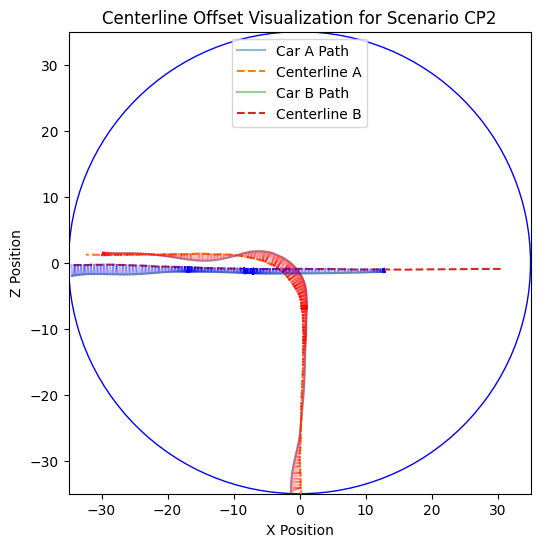

In [19]:
centerline_A = centerlines[scenario,'A']
centerline_B = centerlines[scenario, 'B']

visualize_centerline_offset(innerArea, centerline_A, centerline_B, scenario, MaxDistance)

## Visualize Each Run with Map

In [ ]:
def plot_and_save(Scenario, run, innerArea):
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Time': innerArea['ScenarioTime'],
        'A_HeadPosX': innerArea['HeadPosXA'],
        'A_HeadPosZ': innerArea['HeadPosZA'],
        'B_HeadPosX': innerArea['HeadPosXB'],
        'B_HeadPosZ': innerArea['HeadPosZB']
    })

    # Melt the DataFrame for easier plotting with plotly.express
    plot_df = plot_df.melt(id_vars=['Time'], value_vars=['A_HeadPosX', 'A_HeadPosZ', 'B_HeadPosX', 'B_HeadPosZ'], 
                        var_name='variable', value_name='value')

    # Extract entity and coordinate information from 'variable'
    plot_df[['Entity', 'Coordinate']] = plot_df['variable'].str.extract(r'([AB])_(HeadPos[XYZ])')

    # Separate DataFrames for X and Z coordinates
    df_x = plot_df[plot_df['Coordinate'] == 'HeadPosX']
    df_z = plot_df[plot_df['Coordinate'] == 'HeadPosZ']

    # Merge X and Z coordinates
    plot_df = df_x.merge(df_z, on=['Time', 'Entity'], suffixes=('_X', '_Z'))

    # Create animated scatter plot with plotly.express
    fig = px.scatter(plot_df, x='value_X', y='value_Z', animation_frame='Time', animation_group='Entity', color='Entity',
                    labels={'value_X': 'X-axis', 'value_Z': 'Z-axis'}, range_x=[-MaxDistance, MaxDistance], range_y=[-MaxDistance, MaxDistance])

    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = plot_df['Time'].unique()[1]*1000
    # Add the circle representing the maximum distance using graph_objects
    fig.add_shape(type="circle",
                x0=-MaxDistance, y0=-MaxDistance,
                x1=MaxDistance, y1=MaxDistance,
                line=dict(color="blue"))

    # Update layout to maintain aspect ratio and add title
    fig.update_layout(
        title=f"Scenario: {Scenario}, Run: {run}",
        yaxis_scaleanchor="x",
        yaxis_scaleratio=1
    )
    img1 = base64.b64encode(open('scene.jpeg', 'rb').read())
    r = 0.7
    fig.update_layout(
            images= [dict(
                source='data:image/png;base64,{}'.format(img1.decode()),
                xref="x", yref="y",
                x=-104/r, y=122/r,
                sizex=190/r, sizey=240/r,
                xanchor="left",
                yanchor="top",
                sizing="fill",
                opacity=0.8,
                layer="below")]
                )
    fig.show()

plot_and_save(scenario, location+run, innerArea)

In [ ]:
plt.plot(innerArea['A_Head_DeltaX'])
plt.plot(innerArea['A_Head_VelocityX'])
plt.plot(innerArea['A_Head_DeltaZ'])
plt.plot(innerArea['A_Head_VelocityZ'])
# plt.plot(innerArea['Dot_Product'],color='g')


In [ ]:
innerArea['Filtered_Approach_Vel_Z'] -innerArea['RelVelocity_Z']